<a href="https://colab.research.google.com/github/Nongbon/208499/blob/main/draft_lable_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Nongbon/208499/main/ETH.csv

--2021-09-22 19:09:10--  https://raw.githubusercontent.com/Nongbon/208499/main/ETH.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504403 (493K) [text/plain]
Saving to: ‘ETH.csv.1’

ETH.csv.1           100%[===================>] 492.58K  --.-KB/s    in 0.005s  

2021-09-22 19:09:10 (88.4 MB/s) - ‘ETH.csv.1’ saved [504403/504403]



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates

In [8]:
data = pd.read_csv("ETH.csv").drop(["slug","name","symbol","ref_cur","time_open","time_close","time_high","time_low","id","market_cap"],axis=1)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.rename({'timestamp':'date'},axis=1)
data['date'] = data['date'].map(lambda x: x.rstrip('23:59:59'))
data['date'] = pd.to_datetime(data['date'])
data

,date,open,high,low,close,volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,1.643290e+05
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,6.741880e+05
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06
...,...,...,...,...,...,...
2232,2021-09-16,3613.073624,3673.310899,3489.805745,3571.294935,2.009390e+10
2233,2021-09-17,3569.568210,3589.305140,3356.449969,3398.538778,1.772236e+10
2234,2021-09-18,3397.422739,3540.807599,3371.892406,3432.018235,1.599522e+10
2235,2021-09-19,3433.287959,3448.322105,3286.172425,3329.447895,1.425761e+10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2237 non-null   object 
 1   open    2237 non-null   float64
 2   high    2237 non-null   float64
 3   low     2237 non-null   float64
 4   close   2237 non-null   float64
 5   volume  2237 non-null   float64
dtypes: float64(5), object(1)
memory usage: 105.0+ KB


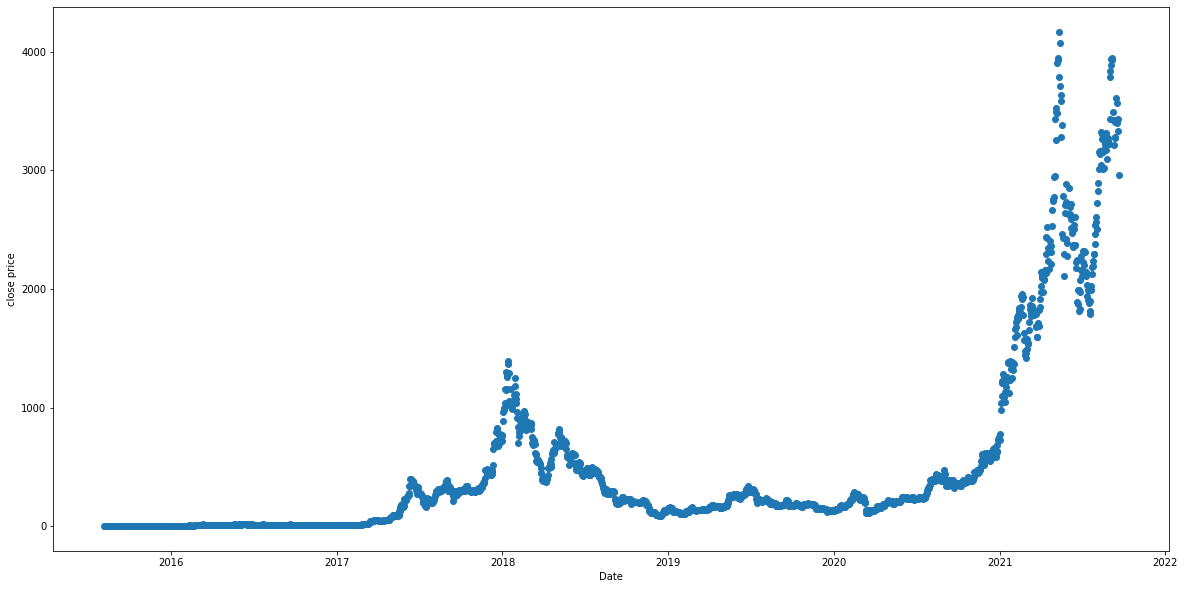

In [9]:
plt.figure(figsize=(20,10))
plt.plot_date(data['date'],data['close'])
plt.xlabel('Date')
plt.ylabel('close price')
plt.show()

In [ ]:
n = len(data)
n

In [ ]:
data['label'] = ''
for i in range(len(data)) :
  if i+1 < n :
    data['label'][i+1] = data['close'][i+1] / data['close'][i]
data

In [ ]:
data['Y'] = ''
for i in range(len(data)) :
  if i+1 < n :
    if data['label'][i+1] > 1 :
      data['Y'][i+1] = 1
    else : 
      data['Y'][i+1] = 0
data

In [ ]:
data.to_csv("label.csv")

### **Input Indicator**

In [ ]:
t_period = 10

# **WMA 10**

In [ ]:
weights = np.arange(1,11)
weights

In [ ]:
data['wma10'] = ''
data['wma10'] = data['close'].rolling(t_period).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True)

## **SMA 10**

In [ ]:
data['sma10'] = ''
data['sma10'] = data['close'].rolling(t_period).mean()

## **Stochastic (%K) 14**

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
k_period = 14
df = []
# Adds a "n_high" column with max value of previous 14 periods
data['n_high'] = data['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
data['n_low'] = data['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
data['%K'] = (data['close'] - data['n_low'])  / (data['n_high'] - data['n_low']) * 100
data

## **RSI**

In [ ]:
from scipy.stats import spearmanr

In [ ]:
cor,p = spearmanr(data['Y'][13:],data['%K'][13:])
print(cor,p)

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data['close'], label="close")
plt.plot(data['wma10'], label="10-Day WMA" , color='lime')
plt.plot(data['sma10'], label="10-Day SMA", color='red')
plt.plot(data['%K'], label="Stochastic 14-Day", color='yellow')
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()